# Data Analysis of "Muscle abnormalities worsen after PEM in longCOVID" with the use of Machine Learning(RF)- Part I

B. Appelman et al. published  ["Muscle abnormalities worsen after post-exertional malaise in long COVID"](https://www.nature.com/articles/s41467-023-44432-3) in 2024 aiming to "provide new insights into the pathophysiology of post-exertional malaise in patients with long COVID."
In this study, they have induced PEM with 25 selected long covid patients and 21 healthy subjects via a cardiopulmonary exercise test on a cycle ergometer.
They have collected: 
- simultaneous ECG, pulmonary gas exchange/ventilation and muscle deoxygenation measurements during the maximal excercise test. 
- blood before the maximal excercise test (baseline), 1 day after and 1 week after
- skeletal muscle biopsies before and after a maximal exercise test
- Self filled surveys
- Steps taken during 1 week before and 1 week after the test.

And using these samples, they have published 100s of metrics for these 46 paticipants: [Source Data](https://www.nature.com/articles/s41467-023-44432-3#Sec31:~:text=Source%20data-,Source%20Data,-Rights%20and%20permissions) 

I have manually preprocessed these dataset (see the project github page) to include the objective measurements (blood, muscle bioptie and excercise test)

In this first part, I do basic data analysis to see the differentiating features (measurements) between healthy and longcovid cohorts. It is not my intention to interpret the data but just present. 

Feature=Feature means, in this context, name of each measurement such as VO2max, or ETS, or LEAK, or CCI...


In [1]:
#hide
from fastbook import *
#from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
import seaborn as sns # data visualization library  
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2
from skfeature.function.information_theoretical_based import CMIM,MRMR,FCBF
from sklearn import metrics 
from sklearn.tree import export_text
from scipy.stats import ttest_ind
from matplotlib.legend_handler import HandlerTuple
import itertools



pd.options.display.max_rows = 30
pd.options.display.max_columns = 10

/Users/bcetin/Documents/personal/projects/data_analysis/fastai/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [3]:
def visualise_features_female(feature_names, num_estimators=50, max_depth=1):
    for n in feature_names:
        clf=rfc_check_clf(X_train=X_female, X_test=X_female, y_train=y_female,y_test=y_female, features=[n],max_depth=max_depth, num_estimators=num_estimators )
        df_female=pd.concat([X_female, y_female], axis=1)
        #draw_tree(clf.estimators_[0], X_female[[n]], size=20, leaves_parallel=True, precision=2)
        plot_feature_scatter(df_female,n,clf.estimators_[0].tree_.threshold[0])

In [4]:
def visualise_features_male(feature_names, num_estimators=50,max_depth=1):
    for n in feature_names:
        clf=rfc_check_clf(X_train=X_male, X_test=X_male, y_train=y_male,y_test=y_male, features=[n],max_depth=max_depth, num_estimators=num_estimators )
        df_male=pd.concat([X_male, y_male], axis=1)
        #draw_tree(clf.estimators_[0], X_female[[n]], size=20, leaves_parallel=True, precision=2)
        plot_feature_scatter(df_male,n,clf.estimators_[0].tree_.threshold[0])

In [5]:
def visualise_features_all(feature_names, num_estimators=50, max_depth=1):
    for n in feature_names:
        clf=rfc_check_clf(X_train=X, X_test=X, y_train=y,y_test=y, features=[n],max_depth=max_depth, num_estimators=num_estimators )
        df=pd.concat([X, y], axis=1)
        #draw_tree(clf.estimators_[0], X_female[[n]], size=20, leaves_parallel=True, precision=2)
        plot_feature_scatter(df,n,clf.estimators_[0].tree_.threshold[0])

In [6]:
def plot_feature_scatter(df,feature_name, split_point, legend=False):
    xx_LC = df[df["Group"]== 2][feature_name]
    yy_LC = df[df["Group"]== 2]["Group"]
    xx_H = df[df["Group"]== 1][feature_name]
    yy_H = df[df["Group"]== 1]["Group"]
    
    plt.figure(figsize = (20, 5))
    plt.scatter(xx_LC, yy_LC, label="Long COVID")
    
    plt.scatter(xx_H, yy_H, label="Healthy")
    
    plt.axvline(x = split_point, color = 'r', label = 'axvline - full height')
    plt.xlabel(feature_name)
    #plt.ylabel('ETS After')
    plt.title(f'Distribution of {feature_name}')
    if legend:
        plt.legend()
    plt.show()

In [7]:
def rfc_check_clf(X_train, X_test, y_train, y_test, features, num_estimators=50, min_samples_leaf=1, max_depth=None, bootstrap=False, oob_score= False):

    X_train_imp = X_train[features]
    X_test_imp = X_test[features]
    
    # creating a RF classifier
    clf = RandomForestClassifier(n_estimators = num_estimators, 
                                 warm_start=True,
                                 oob_score=oob_score,
                                 max_features=None,
                                 max_depth=max_depth,
                                 min_samples_leaf=min_samples_leaf,
                                 bootstrap=bootstrap
                                 ) 
    
    # Training the model on the training dataset
    # fit function is used to train the model using the training sets as parameters
    clf.fit(X_train_imp, y_train)
    
    # performing predictions on the test dataset
    y_pred = clf.predict(X_test_imp)
    
    # metrics are used to find accuracy or error
    
    print()
    
    # using metrics module for accuracy calculation
    print(f"ACCURACY OF THE MODEL for {features}: {metrics.accuracy_score(y_test, y_pred)}")
    return clf

In [9]:
#This function utilizes RFC to find the best split to differentiate between LC and Healthy cohorts 
#and calculates accuracy of the split and p value
def rfc_feature_single_split(df, feature_name, dependent_variable_name="Group"):    
    df_=df[[feature_name, dependent_variable_name]].dropna( axis=0, how="any")
    X_train_imp = df_[[feature_name]]
    X_test_imp = df_[[feature_name]]
    y_train=y_test=df_[dependent_variable_name]
        
        
    #print(f"len(X_train_imp) {len(X_train_imp)}")
    # creating a RF classifier
    clf = RandomForestClassifier(n_estimators = 1, 
                                 max_depth=1,
                                 bootstrap=False
                                 ) 
    
    # Training the model on the training dataset
    # fit function is used to train the model using the training sets as parameters
    clf.fit(X_train_imp, y_train)
    
    # performing predictions on the test dataset
    y_pred = clf.predict(X_test_imp)
    
    
    
    # using metrics module for accuracy calculation
    #print(f"ACCURACY OF THE MODEL for {feature_name}: {metrics.accuracy_score(y_test, y_pred)}")
    return (metrics.accuracy_score(y_test, y_pred), 
            ttest_ind(df_[df_["Group"]==1][feature_name], 
            df_[df_["Group"]==2][feature_name]).pvalue,
            clf.estimators_[0].tree_.threshold[0],
            len(X_train_imp),
            len(df_[df_.Group==1]),
            len(df_[df_.Group==2]))

In [10]:
def rfc_check_accuracy(X_train, X_test, y_train, y_test, features, num_estimators=50, min_samples_leaf=1, max_depth=None, bootstrap=False, oob_score= False, dropna=False):
    
    X_train_imp = X_train[features]
    X_test_imp = X_test[features]

    if dropna:
        y_train=y_train[X_train_imp.isna().any(axis=1) == False]
        y_test=y_test[X_test_imp.isna().any(axis=1) == False]
        X_train_imp=X_train_imp[X_train_imp.isna().any(axis=1) == False]
        X_test_imp =X_test_imp[X_test_imp.isna().any(axis=1) == False]
        
        
    print(f"len(X_train_imp) {len(X_train_imp)}")
    # creating a RF classifier
    clf = RandomForestClassifier(n_estimators = num_estimators, 
                                 warm_start=True,
                                 oob_score=oob_score,
                                 max_features=None,
                                 max_depth=max_depth,
                                 min_samples_leaf=min_samples_leaf,
                                 bootstrap=bootstrap
                                 ) 
    
    # Training the model on the training dataset
    # fit function is used to train the model using the training sets as parameters
    clf.fit(X_train_imp, y_train)
    
    # performing predictions on the test dataset
    y_pred = clf.predict(X_test_imp)
    
    # metrics are used to find accuracy or error
    
    print()
    
    # using metrics module for accuracy calculation
    print(f"ACCURACY OF THE MODEL for {features}: {metrics.accuracy_score(y_test, y_pred)}")
    return metrics.accuracy_score(y_test, y_pred)

In [11]:
def visualise_feature_horizontal(df, feature_ratings_df, feature_name): 
    palette1 = ['white','red']
    palette2 = ['grey','red']
    plt.subplots(figsize=(12, 6))
    ax = sns.boxplot(data=df, y="Group", x=feature_name,
                     hue="Group", hue_order=[1, 2], boxprops={'alpha': 0.4}, palette=palette1,orient="h")
    sns.stripplot(data=df, y="Group", x=feature_name,
                  hue="Group", hue_order=[1, 2], dodge=False, ax=ax, palette=palette2,orient="h")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=[(handles[0], handles[2]), (handles[1], handles[3])],
              labels=['Healthy', 'LC'],
              loc='best', handlelength=4,
              handler_map={tuple: HandlerTuple(ndivide=None)})
    ax.axvline(feature_ratings_df[feature_ratings_df.feature_name==feature_name].best_split.to_numpy()[0], ls='--')
    print(f"accuracy = {feature_ratings_df[feature_ratings_df.feature_name==feature_name].accuracy.to_numpy()[0]}")
    print(f"p value = {feature_ratings_df[feature_ratings_df.feature_name==feature_name].pvalue.to_numpy()[0]}")
    print(f"best split value = {feature_ratings_df[feature_ratings_df.feature_name==feature_name].best_split.to_numpy()[0]}")
    print(f"#samplesHealthy = {feature_ratings_df[feature_ratings_df.feature_name==feature_name].numsamples_Healthy.to_numpy()[0]}")
    print(f"#samplesLC = {feature_ratings_df[feature_ratings_df.feature_name==feature_name].numsamples_LC.to_numpy()[0]}")
def visualise_feature_vertical(df, feature_ratings_df, feature_name): 
    palette1 = ['white','red']
    palette2 = ['grey','red']
    plt.subplots(figsize=(6, 7))
    ax = sns.boxplot(data=df, x="Group", y=feature_name,
                     hue="Group", hue_order=[1, 2], boxprops={'alpha': 0.4}, palette=palette1)
    sns.stripplot(data=df, x="Group", y=feature_name,
                  hue="Group", hue_order=[1, 2], dodge=False, ax=ax, palette=palette2)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=[(handles[0], handles[2]), (handles[1], handles[3])],
              labels=['Healthy', 'LC'],
              loc='best', handlelength=4,
              handler_map={tuple: HandlerTuple(ndivide=None)})
    ax.axhline(feature_ratings_df[feature_ratings_df.feature_name==feature_name].best_split.to_numpy()[0], ls='--')
    print(f"accuracy = {feature_ratings_df[feature_ratings_df.feature_name==feature_name].accuracy.to_numpy()[0]}")
    print(f"p value = {feature_ratings_df[feature_ratings_df.feature_name==feature_name].pvalue.to_numpy()[0]}")
    print(f"best split value = {feature_ratings_df[feature_ratings_df.feature_name==feature_name].best_split.to_numpy()[0]}")
    print(f"#samplesHealthy = {feature_ratings_df[feature_ratings_df.feature_name==feature_name].numsamples_Healthy.to_numpy()[0]}")
    print(f"#samplesLC = {feature_ratings_df[feature_ratings_df.feature_name==feature_name].numsamples_LC.to_numpy()[0]}")

In [12]:
def visualise_feature(df, split_point, feature_name): 
    palette1 = ['white','red']
    palette2 = ['grey','red']
    plt.subplots(figsize=(6, 7))
    ax = sns.boxplot(data=df, x="Group", y=feature_name,
                     hue="Group", hue_order=[1, 2], boxprops={'alpha': 0.4}, palette=palette1)
    sns.stripplot(data=df, x="Group", y=feature_name,
                  hue="Group", hue_order=[1, 2], dodge=False, ax=ax, palette=palette2)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=[(handles[0], handles[2]), (handles[1], handles[3])],
              labels=['Healthy', 'LC'],
              loc='best', handlelength=4,
              handler_map={tuple: HandlerTuple(ndivide=None)})
    ax.axhline(split_point, ls='--')
    

In [14]:
def visualize_baseline_and_after(df,feature1,feature2):
    plt.subplots(figsize=(6, 7))
    feature=feature1.split("_before")[0]
    df_1=df[["Group",feature1]]
    df_1=df_1.rename(columns={feature1:feature})
    df_1["Time"]="baseline"
    df_1["ID"]=df_1.index
    df_2=df[["Group",feature2]]
    df_2=df_2.rename(columns={feature2:feature})
    df_2["Time"]="1_day_after"
    df_2["ID"]=df_2.index
    
    df_=pd.concat([df_1, df_2],axis=0, sort=False, ignore_index=True)
    
    palette1 = ['white','red']
    palette2 = ['grey','red']
    ax = sns.boxplot(data=df_, x="Time", y="ETS",
                     hue="Group", hue_order=[1, 2], boxprops={'alpha': 0.4}, palette=palette1)
    sns.stripplot(data=df_, x="Time", y="ETS",
                  hue="Group", hue_order=[1,2], dodge=True, ax=ax, palette=palette2)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=[(handles[0], handles[2]), (handles[1], handles[3])],
              labels=['Healthy', 'LC'],
              loc='best', handlelength=4,
              handler_map={tuple: HandlerTuple(ndivide=None)})

## Importing the data

"LongCovid_muscleME_dataset_adjusted.xlsx" excel file holds the data of 47 subjects measurement data. It is a 47 x 945 matrix.

In [15]:
df=pd.read_excel("LongCovid_muscleME_dataset_adjusted.xlsx",index_col='ID')

In [16]:
df

,Group,sex,LEAK_before,NAD_linked_complex_1_before,ETS_before,...,bmi,CCI,VO2max,peakpoweroutput,GET
ID,,,,,,,,,,,
1,Long COVID,Female,20.96155,37.79055,84.63940,...,26.57,0,NaN,49,NaN
2,Long COVID,Female,6.55440,34.20010,64.04970,...,23.30,0,22.812785,214,1.43
3,Long COVID,Female,15.44015,51.07100,110.71045,...,21.26,0,29.568523,163,1.47
4,Long COVID,Female,11.33050,28.93250,64.70440,...,27.09,1,22.240763,169,1.45
5,Long COVID,Female,8.36740,31.42710,85.38575,...,23.72,0,29.399302,170,1.80
...,...,...,...,...,...,...,...,...,...,...,...
42,Healthy,Female,12.02150,46.28210,134.90030,...,21.60,0,41.461594,283,2.17
43,Healthy,Male,13.73405,57.38995,148.81235,...,29.04,0,29.976442,231,1.66
44,Healthy,Male,11.14725,55.42075,147.74845,...,29.22,0,27.211392,256,1.73


Here I convert the strings into codes/numbers. Nothing fancy.

In [17]:
df.Group=df.Group.astype('category').cat.codes+1 #1:Healthy 2:Long Covid

In [18]:
df.sex=df.sex.astype('category').cat.codes+1 #1:female 2:male

## FEMALE and MALE

Let's first do an analyze of the whole dataset without seperating the two genders. Here I check every single feature one by one to see how they would perform to predict whether the participant was Helathy or Long covid with only one single split. I utilise random forest classifier from skicit learn to do the job for me. Let's start with an example. I will use LEAK_before (LEAK measurement before the excercise test) feature for the example and let's see how successful can LEAK measurements be to seperate the groups.

Here is the question that I am looking for an answer to: What is the best splitting point of LEAK_before feature that will yield the best accuracy to predict in which "Group" the paricipant sits?

In [19]:
features=["LEAK_before"]
X_train_imp = X_test_imp= df[features]
y_train=y_test=df["Group"]

In [20]:
# creating a RF classifier
clf = RandomForestClassifier(n_estimators = 1, 
                             max_features=None,
                             max_depth=1,
                             bootstrap=False
                             ) 

# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf.fit(X_train_imp, y_train)

# performing predictions on the test dataset
y_pred = clf.predict(X_test_imp)

# using metrics module for accuracy calculation
print(f"ACCURACY OF THE MODEL for {features}: {metrics.accuracy_score(y_test, y_pred)}")

ACCURACY OF THE MODEL for ['LEAK_before']: 0.7391304347826086


The accuracy of "LEAK_before" feature is 74% to predict the "Group" of a participant. And here how it works:
- It builds a tree, with single split point at 9.69.
- If the value us smaller than or equal to our split point, it classifies for Long Covid
- Otherwise Healthy

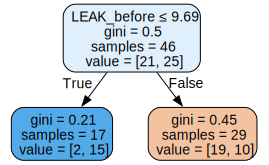

In [21]:
draw_tree(clf.estimators_[0], X_train_imp, size=20, leaves_parallel=True, precision=2)

Here is a boxplot representation of the same thing. Dashed blue line is our split point. If you count it yourself, there are 2 Healthy below the line and 10 LC over the line which will result in wrong prediction. (46-12)/46 is our accuracy

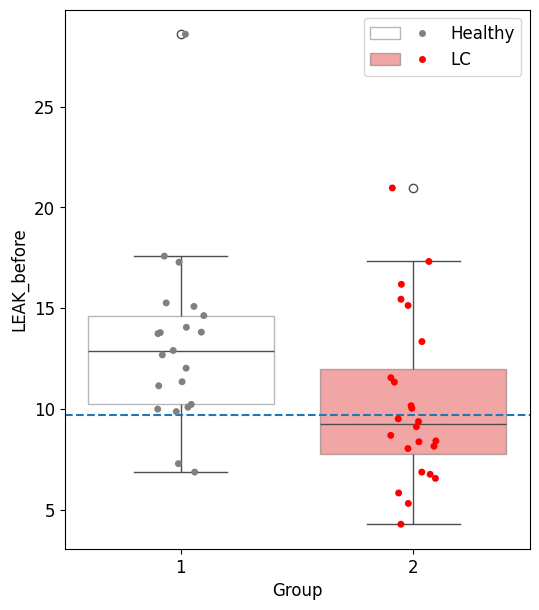

In [22]:
visualise_feature(df,split_point=clf.estimators_[0].tree_.threshold[0],feature_name="LEAK_before")

In [23]:
(46-12)/46

0.7391304347826086

Now you got the idea let's streamline the above calculation for all our features and build a dataframe

In [24]:
feature_ratings_all={c:dict(zip(["accuracy","pvalue","best_split","numsamples","numsamples_Healthy","numsamples_LC"],rfc_feature_single_split(df,c))) for c in df.drop(columns=["Group","sex"])}
_ = pd.DataFrame(feature_ratings_all.items(),columns=['feature_name',1])
feature_ratings_all_df = pd.concat([_.drop(columns=[1]),pd.json_normalize(_[1])], axis=1)
del(_)

/Users/bcetin/Documents/personal/projects/data_analysis/fastai/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/Users/bcetin/Documents/personal/projects/data_analysis/fastai/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/Users/bcetin/Documents/personal/projects/data_analysis/fastai/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_

As you can see below, we built our dataframe with each feature checked and calculated the accuracy, pvalue and best_split point. We are only checking for single split scenario for simpicity (for now). If you are wondering why the sample number differes, in some features, we have missing measurements. That is the reason.

In [25]:
feature_ratings_all_df

,feature_name,accuracy,pvalue,best_split,numsamples,numsamples_Healthy,numsamples_LC
0,LEAK_before,0.733333,0.026988,9.687800,45,21,24
1,NAD_linked_complex_1_before,0.711111,0.002284,35.635250,45,21,24
2,ETS_before,0.822222,0.000009,114.414173,45,21,24
3,ETS_after,0.866667,0.000050,102.757225,45,20,25
4,s_linked_complex_2_before,0.844444,0.000061,54.151051,45,21,24
...,...,...,...,...,...,...,...
936,bmi,0.565217,0.236081,29.445000,46,21,25
937,CCI,0.543478,0.697044,2.500000,46,21,25
938,VO2max,0.750000,0.000541,29.772483,44,21,23
939,peakpoweroutput,0.760870,0.001377,225.500000,46,21,25


Let's look at the features that scored the top accuracy.

In [26]:
feature_ratings_all_df[feature_ratings_all_df["accuracy"]>=0.80].sort_values('accuracy',ascending=False)

,feature_name,accuracy,pvalue,best_split,numsamples,numsamples_Healthy,numsamples_LC
3,ETS_after,0.866667,0.000050,102.757225,45,20,25
4,s_linked_complex_2_before,0.844444,0.000061,54.151051,45,21,24
2,ETS_before,0.822222,0.000009,114.414173,45,21,24
461,CMP_blood_1W_after,0.804348,0.011012,0.008267,46,21,25
770,Dihydroxyacetone-P_blood_1W_afterto1D_change%,0.804348,0.006955,-0.322996,46,21,25


ETS value (both before and after) are providing us with good predictions, they also have quite low p values.

accuracy = 0.8222222222222222
p value = 8.576213798363037e-06
best split value = 114.4141731262207
#samplesHealthy = 21
#samplesLC = 24


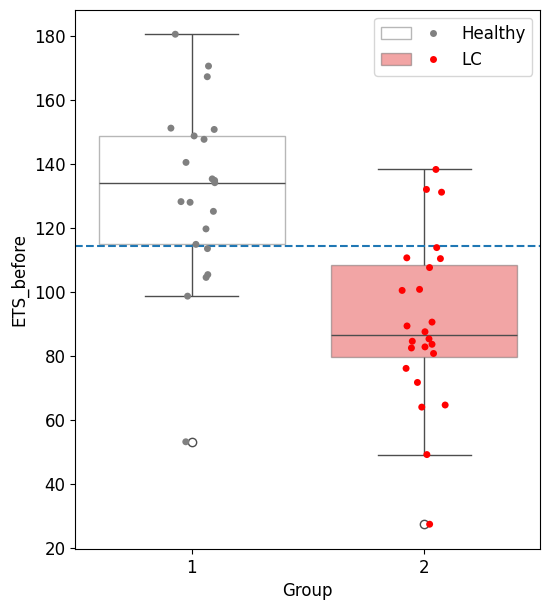

In [27]:
visualise_feature_vertical(df,feature_ratings_all_df,"ETS_before")

accuracy = 0.8666666666666667
p value = 5.012976532179057e-05
best split value = 102.7572250366211
#samplesHealthy = 20
#samplesLC = 25


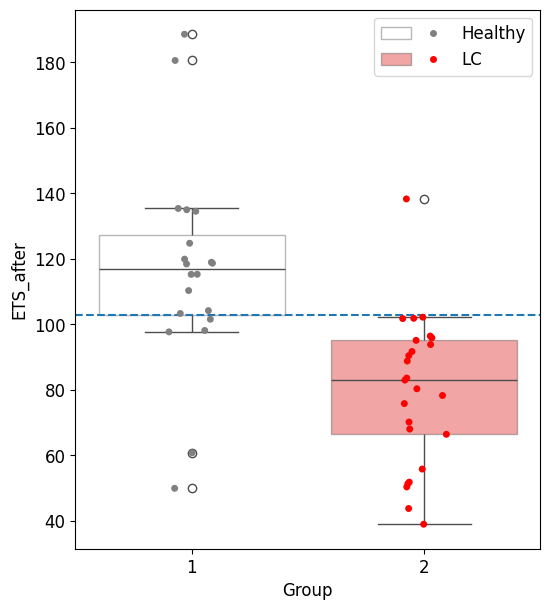

In [28]:
visualise_feature_vertical(df,feature_ratings_all_df,"ETS_after")

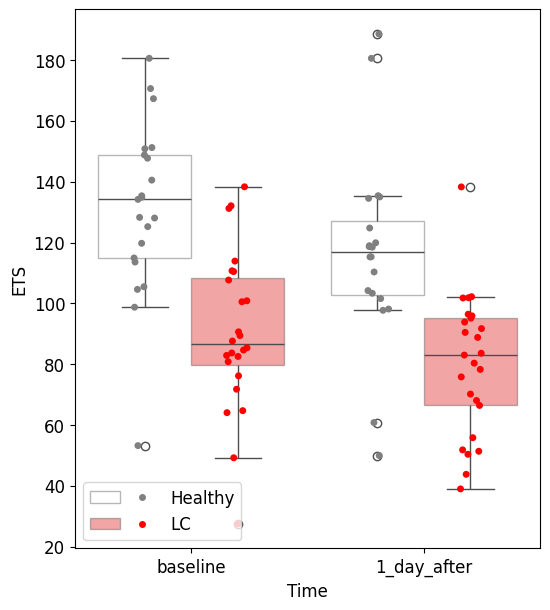

In [29]:
visualize_baseline_and_after(df,"ETS_before","ETS_after")

what if we split the participants based on gender and do the same check?

### FEMALE

In [30]:
df_female=df[df.sex==1]
feature_ratings_female={c:dict(zip(["accuracy","pvalue","best_split","numsamples","numsamples_Healthy","numsamples_LC"],rfc_feature_single_split(df_female,c))) for c in df.drop(columns=["Group","sex"])}
_ = pd.DataFrame(feature_ratings_female.items(),columns=['feature_name',1])
feature_ratings_female_df = pd.concat([_.drop(columns=[1]),pd.json_normalize(_[1])], axis=1)
del(_)

/Users/bcetin/Documents/personal/projects/data_analysis/fastai/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/Users/bcetin/Documents/personal/projects/data_analysis/fastai/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/Users/bcetin/Documents/personal/projects/data_analysis/fastai/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_

In [31]:
feature_ratings_female_df[feature_ratings_female_df["accuracy"]>=0.8].sort_values('accuracy',ascending=False)

,feature_name,accuracy,pvalue,best_split,numsamples,numsamples_Healthy,numsamples_LC
4,s_linked_complex_2_before,0.916667,0.000361,54.060026,24,11,13
688,FAICAR_blood_1W_after_change%,0.916667,0.000034,0.189196,24,11,13
3,ETS_after,0.913043,0.000341,102.757225,23,10,13
258,Uracil_after,0.909091,0.017674,0.000140,22,10,12
217,Hydroxyphenyllactic acid_after,0.909091,0.016790,0.003173,22,10,12
...,...,...,...,...,...,...,...
909,Phenylalanine_after_change%,0.800000,0.220685,0.246531,20,8,12
896,Lysine_after_change%,0.800000,0.105130,0.170901,20,8,12
857,Citrulline_after_change%,0.800000,0.110128,-0.004446,20,8,12
822,2-Hydroxyglutarate_after_change%,0.800000,0.680561,-0.369282,20,8,12


As expected, we have much more features sticking out. There are 5 features which can predict with >90% accuracy, ETS_after being one of them.

accuracy = 0.9130434782608695
p value = 0.0003405264738153746
best split value = 102.7572250366211
#samplesHealthy = 10
#samplesLC = 13


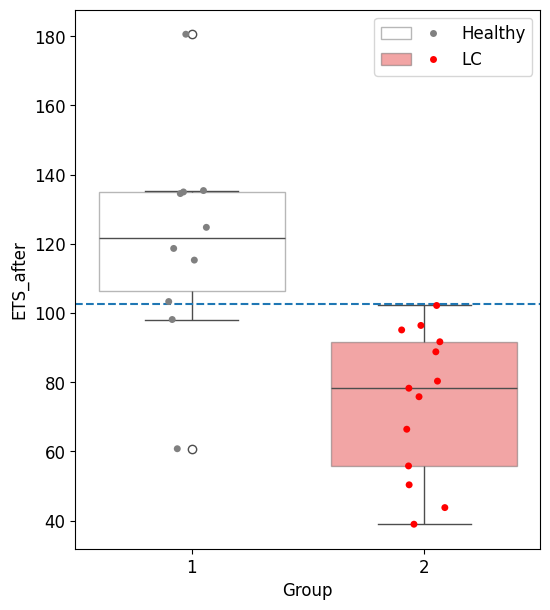

In [34]:
visualise_feature_vertical(df_female,feature_ratings_female_df,"ETS_after")

accuracy = 0.875
p value = 0.0017643131449922187
best split value = 114.4141731262207
#samplesHealthy = 11
#samplesLC = 13


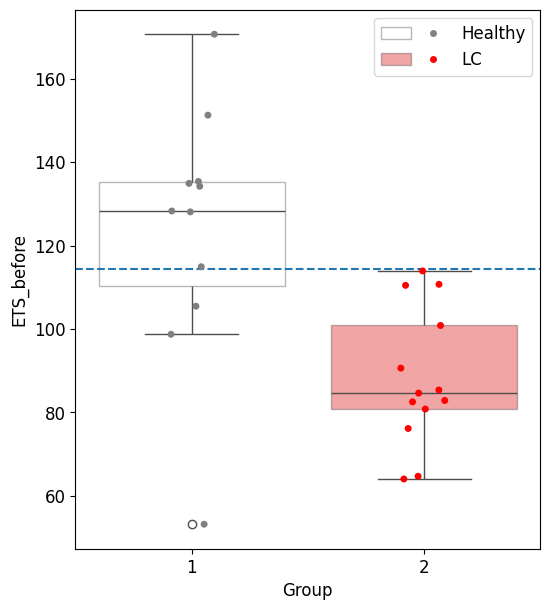

In [35]:
visualise_feature_vertical(df_female,feature_ratings_female_df,"ETS_before")

### MALE

In [36]:
df_male=df[df.sex==2]
feature_ratings_male={c:dict(zip(["accuracy","pvalue","best_split","numsamples","numsamples_Healthy","numsamples_LC"],rfc_feature_single_split(df_male,c))) for c in df.drop(columns=["Group","sex"])}
_ = pd.DataFrame(feature_ratings_male.items(),columns=['feature_name',1])
feature_ratings_male_df = pd.concat([_.drop(columns=[1]),pd.json_normalize(_[1])], axis=1)
del(_)

/Users/bcetin/Documents/personal/projects/data_analysis/fastai/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/Users/bcetin/Documents/personal/projects/data_analysis/fastai/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/Users/bcetin/Documents/personal/projects/data_analysis/fastai/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_

In [37]:
feature_ratings_male_df[feature_ratings_male_df["accuracy"]>=0.8].sort_values('accuracy',ascending=False)

,feature_name,accuracy,pvalue,best_split,numsamples,numsamples_Healthy,numsamples_LC
787,Histidine_blood_1W_afterto1D_change%,0.954545,0.005461,0.201556,22,10,12
461,CMP_blood_1W_after,0.954545,0.002679,0.008273,22,10,12
399,Histidine_blood_1D_after,0.909091,0.000471,7.325747,22,10,12
770,Dihydroxyacetone-P_blood_1W_afterto1D_change%,0.909091,0.172082,-0.430434,22,10,12
765,CMP_blood_1W_afterto1D_change%,0.909091,0.007520,0.176400,22,10,12
...,...,...,...,...,...,...,...
938,VO2max,0.809524,0.004738,36.555305,21,10,11
2,ETS_before,0.809524,0.001992,102.557301,21,10,11
4,s_linked_complex_2_before,0.809524,0.018935,58.076275,21,10,11
251,Taurine_after,0.809524,0.044326,1.807434,21,9,12


Let's combine female and male dataframes and make a combined sort so check on the features both scoring good accuracy

In [38]:
df_accuracy_male_female=pd.concat([feature_ratings_male_df.set_index("feature_name").rename(columns={c:f"{c}_male" for c in feature_ratings_male_df}), feature_ratings_female_df.set_index("feature_name").rename(columns={c:f"{c}_female" for c in feature_ratings_female_df})], axis=1)

In [39]:
df_accuracy_male_female["accuracy_combined"]=((df_accuracy_male_female["accuracy_female"]*df_accuracy_male_female["numsamples_Healthy_female"])+(df_accuracy_male_female["accuracy_male"]*df_accuracy_male_female["numsamples_Healthy_male"]))/(df_accuracy_male_female["numsamples_Healthy_male"]+df_accuracy_male_female["numsamples_Healthy_female"])

In [40]:
df_accuracy_male_female=df_accuracy_male_female.reindex(sorted(df_accuracy_male_female.columns), axis=1)

In [41]:
df_accuracy_male_female[df_accuracy_male_female["accuracy_male"]>0.8][df_accuracy_male_female["accuracy_female"]>0.8].sort_values('accuracy_combined',ascending=False)

/var/folders/hf/v1htyrg153x1y7lpbcltlh0m0000gp/T/ipykernel_41915/846929978.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_accuracy_male_female[df_accuracy_male_female["accuracy_male"]>0.8][df_accuracy_male_female["accuracy_female"]>0.8].sort_values('accuracy_combined',ascending=False)


,accuracy_combined,accuracy_female,accuracy_male,best_split_female,best_split_male,...,numsamples_LC_male,numsamples_female,numsamples_male,pvalue_female,pvalue_male
feature_name,,,,,,,,,,,
s_linked_complex_2_before,0.865646,0.916667,0.809524,54.060026,58.076275,...,11,24,21,0.000361,0.018935
ETS_after,0.865613,0.913043,0.818182,102.757225,96.795624,...,12,23,22,0.000341,0.043177
ETS_before,0.843821,0.875000,0.809524,114.414173,102.557301,...,11,24,21,0.001764,0.001992
Glucose-6P_blood_1W_afterto1D_change%,0.826118,0.833333,0.818182,-0.052513,-0.211742,...,12,24,22,0.009426,0.366594
peakpoweroutput,0.826118,0.833333,0.818182,172.000000,227.500000,...,12,24,22,0.001686,0.005586


### Random Forest - Machine Learning Model

Let's build our first model to predict without putting too much brain on it. And let's use the top 5 features that we came up with above.

In [42]:
interesting_features=df_accuracy_male_female[df_accuracy_male_female["accuracy_male"]>0.8][df_accuracy_male_female["accuracy_female"]>0.8].index.to_list()

/var/folders/hf/v1htyrg153x1y7lpbcltlh0m0000gp/T/ipykernel_41915/2405369345.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  interesting_features=df_accuracy_male_female[df_accuracy_male_female["accuracy_male"]>0.8][df_accuracy_male_female["accuracy_female"]>0.8].index.to_list()


In [43]:
interesting_features_combinations=list(itertools.combinations(interesting_features,5))

In [44]:
RANDOM_STATE = 123 # This is a seed to keep our algo in a deterministic state for now

In [45]:
def rfc_female_and_male(interesting_features, n_estimators=100, max_depth=None, bootstrap=True, test_size=0.2):
    interesting_features.append("Group")
    interesting_features.append("sex")
    df_interesting=df[interesting_features]
    df_interesting=df_interesting.dropna()
    
    X_male = df_interesting[df_interesting['sex']==2].drop(['sex'], axis=1)
    y_male = X_male['Group']
    X_male = X_male.drop(['Group'], axis=1)
    X_female = df_interesting[df_interesting['sex']==1].drop(['sex'], axis=1)
    y_female = X_female['Group']
    X_female = X_female.drop(['Group'], axis=1)
    
    X_male_train, X_male_test, y_male_train, y_male_test = train_test_split(X_male,
                                                       y_male,
                                                       test_size=test_size,
                                                       shuffle=True,
                                                       stratify=y_male,
                                                       random_state=RANDOM_STATE)
    X_female_train, X_female_test, y_female_train, y_female_test = train_test_split(X_female,
                                                       y_female,
                                                       test_size=test_size,
                                                       shuffle=True,
                                                       stratify=y_female,
                                                       random_state=RANDOM_STATE)
    
    # creating a RF classifier
    clf_male = RandomForestClassifier(n_estimators = n_estimators, 
                                 warm_start=False,
                                 oob_score=False,
                                 max_features=None,
                                max_depth=max_depth,
                                      bootstrap=bootstrap,
                                      n_jobs=-1
                                 ) 
    
    # Training the model on the training dataset
    # fit function is used to train the model using the training sets as parameters
    clf_male.fit(X_male_train, y_male_train)
    
    # performing predictions on the test dataset
    y_male_pred = clf_male.predict(X_male_test)
    
    # metrics are used to find accuracy or error
    
    print()
    
    # using metrics module for accuracy calculation
    accuracy_male=metrics.accuracy_score(y_male_test, y_male_pred)
    print("ACCURACY OF THE MODEL MALE:", accuracy_male)
    
    clf_female = RandomForestClassifier(n_estimators = n_estimators, 
                                 warm_start=False,
                                 oob_score=False,
                                 max_features=None,
                                max_depth=max_depth,
                                        bootstrap=bootstrap,
                                        n_jobs=-1
                                 ) 
    
    # Training the model on the training dataset
    # fit function is used to train the model using the training sets as parameters
    clf_female.fit(X_female_train, y_female_train)
    
    # performing predictions on the test dataset
    y_female_pred = clf_female.predict(X_female_test)
    
    # metrics are used to find accuracy or error
     
    print()
    
    # using metrics module for accuracy calculation
    accuracy_female=metrics.accuracy_score(y_female_test, y_female_pred)
    print("ACCURACY OF THE MODEL FEMALE:", accuracy_female)
    accuracy=metrics.accuracy_score(np.concatenate((y_male_test.to_numpy(), y_female_test.to_numpy())),np.concatenate((y_male_pred, y_female_pred)))
    print("ACCURACY OF THE MODEL COMBINED:", accuracy)
    if accuracy==2:
        print("Bingo!!!!!!!!!!!")

    
    return metrics.accuracy_score(y_male_test, y_male_pred),metrics.accuracy_score(y_female_test, y_female_pred)


In [46]:
interesting_features_combinations=list(itertools.combinations(interesting_features,5))

In [47]:
d={i:rfc_female_and_male(list(i), max_depth=None, n_estimators=1, bootstrap=False, test_size=0.2) for i in interesting_features_combinations}


ACCURACY OF THE MODEL MALE: 1.0

ACCURACY OF THE MODEL FEMALE: 0.8
ACCURACY OF THE MODEL COMBINED: 0.9


90% in our first try is definetely promising. On top of all the explanation that we got from the author's of the paper, personally I am convinced this dataset has clear objective measurements that seperates both groups in quite an acceptable level.  